## Importaciones

In [76]:
import pandas as pd, numpy as np

import matplotlib.pyplot as plt
# Grafica en formato retina
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Vectorizadores
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# descarga las stopwords en español y guardalas en una lista
from nltk.corpus import stopwords
import string 
from nltk.tokenize import word_tokenize
stopwords = set(stopwords.words('spanish'))

# Import librería para simular SNN
from brian2 import *

from sklearn.feature_extraction.text import TfidfVectorizer


WARNING    /var/folders/d9/9kxdpj_1093dfyt04_xwd8v80000gn/T/ipykernel_38700/1976024119.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')
 [py.warnings]


## Funciones

In [2]:
def vectorize_text(train_data, test_data, min_df, ngrams, stop_words_lang):
    # Vectorizar texto
    vectorizer = TfidfVectorizer(min_df=min_df, 
                                ngram_range=ngrams, 
                                stop_words=stop_words_lang)
    tfidf_train = vectorizer.fit_transform(train_data).toarray()
    tfidf_test = [vectorizer.transform(subset).toarray() for subset in test_data]
    
    return vectorizer, tfidf_train, tfidf_test

In [31]:
def snn_vanilla_4_text(tfidf_matrix, input_neuron_number, hidden_neuron_number=50, 
                       alpha=1.5, tau=100*ms, u_rest=-65*mV, u_exc=0*mV, u_inh=-90*mV, 
                       u_th=-52*mV, t_ref=3*ms, tau_e=2*ms, tau_i=2*ms, tau_A=5*ms, 
                       tau_R=70*ms, n=0.01, w_max=1, run_time=600*ms, S_inicial=None):
    """
    Simula una SNN utilizando el modelo LIF con plasticidad STDP para procesar datos TF-IDF.
    
    Si S_inicial es None, se inicializan los pesos aleatoriamente. Los pesos ajustados se devuelven.
    """
    start_scope()
    # Definición del modelo de neurona LIF
    eqs = '''
    du/dt = ((u_rest - u) + g_e*(u_exc - u) + g_i*(u_inh - u)) / tau : volt (unless refractory)
    dg_e/dt = -g_e / tau_e : 1
    dg_i/dt = -g_i / tau_i : 1 
    '''

    # Inicialización de pesos si no se proporcionan
    if S_inicial is None:
        S_inicial = np.random.uniform(low=0, high=w_max, size=(input_neuron_number, hidden_neuron_number))

    updated_weights = S_inicial  # Copia inicial de los pesos para actualizaciones
    bandera=0

    for doc in range(tfidf_matrix.shape[0]):
        print(bandera)
        rates = tfidf_matrix[doc] * alpha * Hz
        P = PoissonGroup(input_neuron_number, rates=rates)
        
        G = NeuronGroup(hidden_neuron_number, eqs, threshold='u > u_th', reset='u = u_rest', refractory=t_ref, method='euler')

        # Sinapsis con plasticidad STDP
        eqs_plasticity = '''
        dA/dt = -A / tau_A : 1 (event-driven)
        dR/dt = -R / tau_R : 1 (event-driven)
        w : 1
        '''
        on_pre = '''
        A += 1
        w = clip(w + (n * (A - (R + 0.1) * w)), 0, w_max)
        '''
        on_post = '''
        R += 1
        '''

        S = Synapses(P, G, model=eqs_plasticity, on_pre=on_pre, on_post=on_post)
        S.connect()
        
        for idx in range(len(S.i)):
            S.w[idx] = S_inicial[S.i[idx], S.j[idx]] # Inicialización basada en pesos anteriores

        # Monitores para la visualización
        M_spikes = SpikeMonitor(G)
        M = StateMonitor(G, 'u', record=True)

        spikemon_in = SpikeMonitor(P) #records spikes from input neurons
        spikemon_out = SpikeMonitor(G)

        run(run_time)

        # Actualización de los pesos para la siguiente iteración
        updated_weights = S.w[:]
        bandera+=1

    return updated_weights, M_spikes, M, spikemon_in, spikemon_out

In [5]:
def plot_spikes(M_spikes, M):
    # Visualización
    figure(figsize=(12, 6))
    subplot(121)
    plot(M_spikes.t/ms, M_spikes.i, '.k')
    xlim(0, 600)
    xlabel('Tiempo (ms)')
    ylabel('Índice de neurona')

    subplot(122)
    plot(M.t/ms, M.u[0]/mV)
    xlabel('Tiempo (ms)')
    ylabel('Potencial de membrana (mV)')

    show()

## Implementación

### Data

In [85]:
data_path = '../Data/hwxpi/clean/'
train = pd.read_csv(data_path + 'hwxpis_train.csv')
dev = pd.read_csv(data_path + 'hwxpis_dev.csv')
test = pd.read_csv(data_path + 'hwxpis_test.csv')

In [86]:
# Obten los valores a partir de la columna 4 en adelante de train y guarda cada linea como una lista, de tal manera que  y_train sea una lista de listas
y_train = train.iloc[:, 5:].values.tolist()
y_dev = dev.iloc[:, 5:].values.tolist()
y_test = test.iloc[:, 5:].values.tolist()

#### Train

In [87]:
# Obten los indices de y_train donde el primer valor de cada vector sea igual a 1
y_train_extraversion = [i for i, x in enumerate(y_train) if x[0] == 1]
y_train_agreeableness = [i for i, x in enumerate(y_train) if x[1] == 1]
y_train_conscientiousness = [i for i, x in enumerate(y_train) if x[2] == 1]
y_train_neuroticism = [i for i, x in enumerate(y_train) if x[3] == 1]
y_train_openness = [i for i, x in enumerate(y_train) if x[4] == 1]

In [88]:
# Obtener los valores de tfidf_raw_text que corresponden a los indices de y_train_extraversion
tfidf_raw_text_extraversion = [train['raw_text_no_lbls'][i] for i in y_train_extraversion]
tfidf_raw_text_agreeableness = [train['raw_text_no_lbls'][i] for i in y_train_agreeableness]
tfidf_raw_text_conscientiousness = [train['raw_text_no_lbls'][i] for i in y_train_conscientiousness]
tfidf_raw_text_neuroticism = [train['raw_text_no_lbls'][i] for i in y_train_neuroticism]
tfidf_raw_text_openness = [train['raw_text_no_lbls'][i] for i in y_train_openness]

In [99]:
def plot_sample_distribution(categories, sample_values, colors, title):
    plt.figure(figsize=(10, 6))  # Ajusta el tamaño del gráfico
    bars = plt.bar(categories, sample_values, color=colors)
    plt.xlabel('Categoría')
    plt.ylabel('Número de muestras')
    plt.title(title)
    
    # Añade etiquetas dentro de las barras
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')
    
    plt.tight_layout()  # Asegura que todo el contenido se muestre bien
    plt.show()

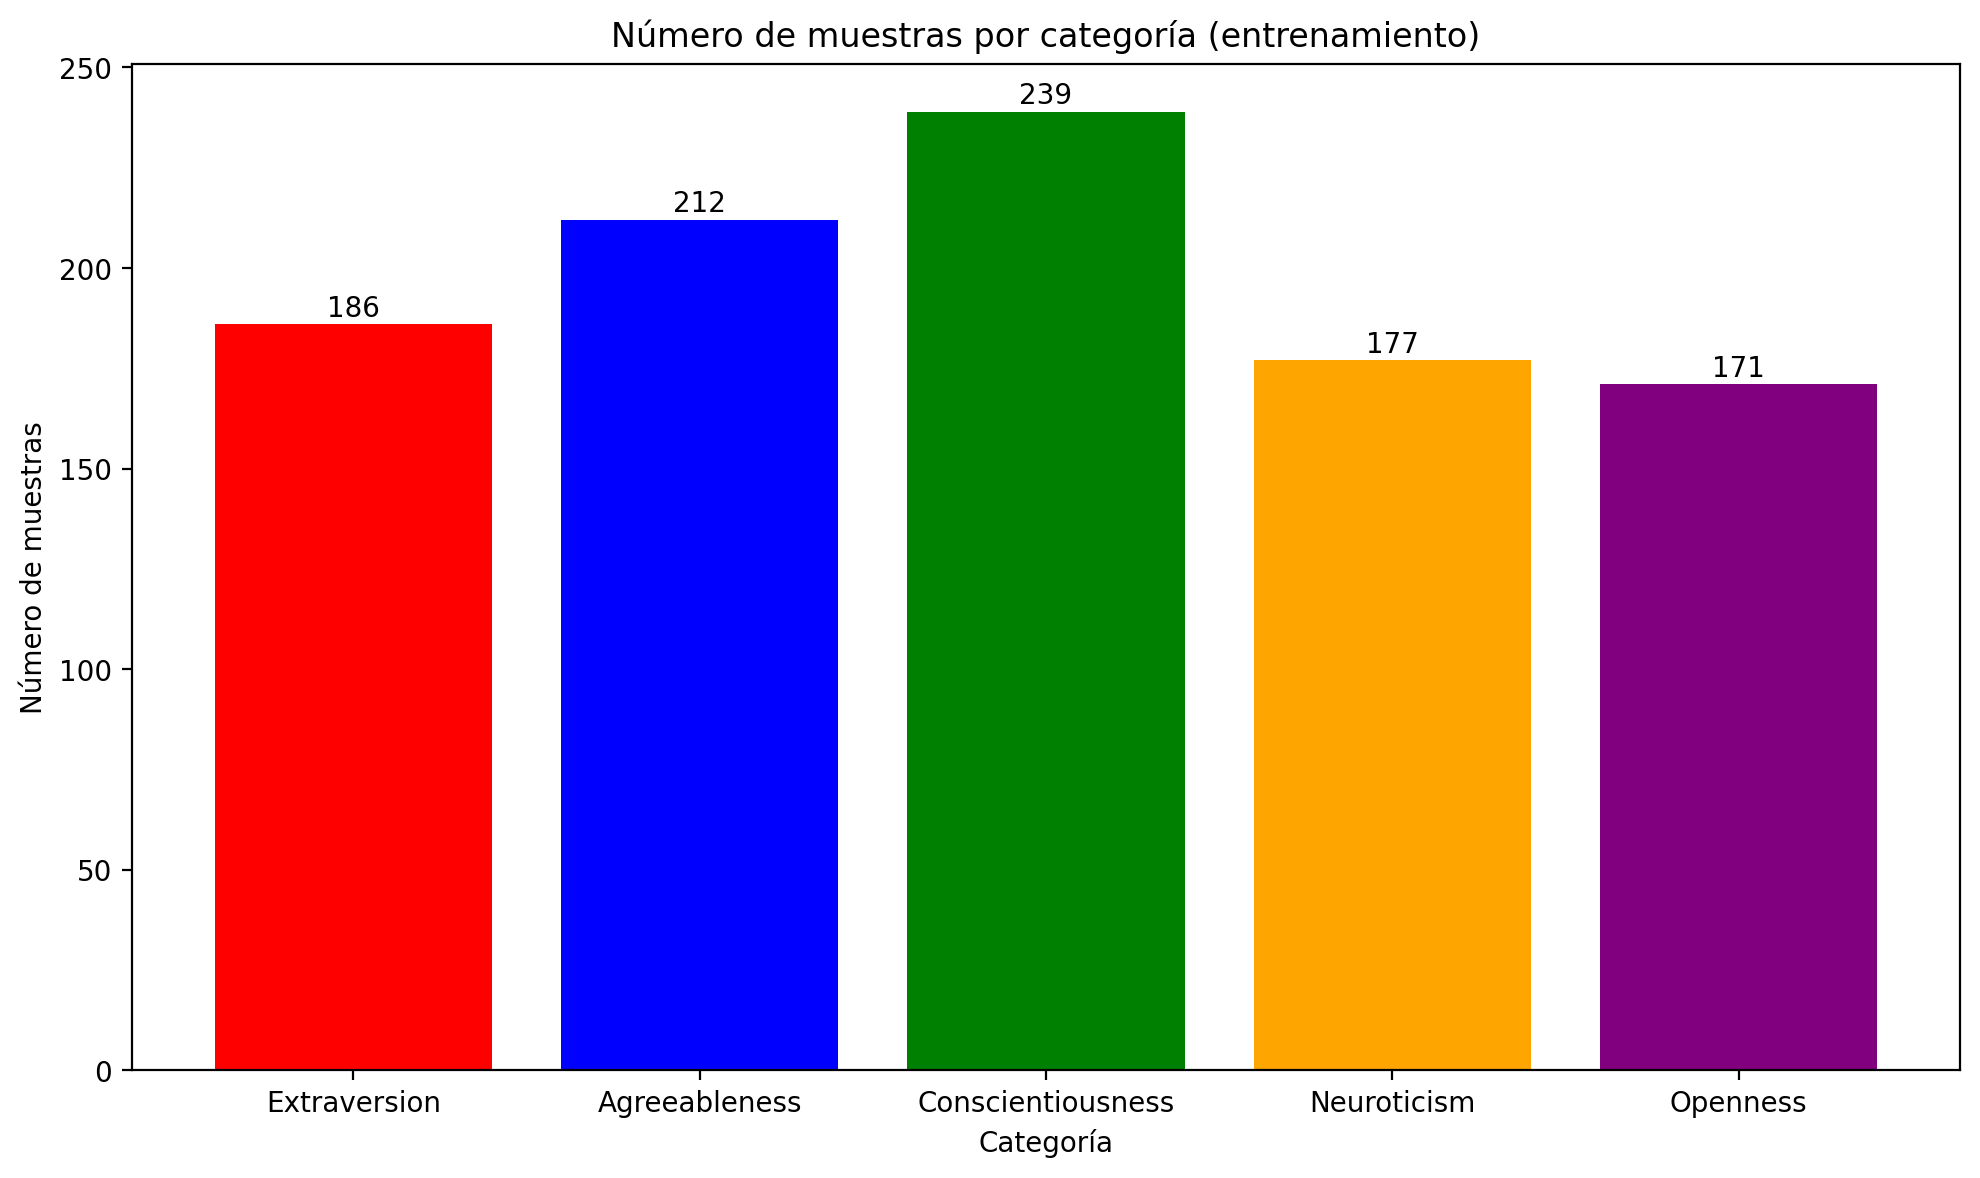

In [100]:
categorias = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']
colors = ['red', 'blue', 'green', 'orange', 'purple']
muestras = [len(y_train_extraversion), len(y_train_agreeableness), len(y_train_conscientiousness), len(y_train_neuroticism), len(y_train_openness)]

plot_sample_distribution(categorias, muestras, colors, 'Número de muestras por categoría (entrenamiento)')

#### Dev

In [90]:
# Obten los indices de y_train donde el primer valor de cada vector sea igual a 1
y_dev_extraversion = [i for i, x in enumerate(y_dev) if x[0] == 1]
y_dev_agreeableness = [i for i, x in enumerate(y_dev) if x[1] == 1]
y_dev_conscientiousness = [i for i, x in enumerate(y_dev) if x[2] == 1]
y_dev_neuroticism = [i for i, x in enumerate(y_dev) if x[3] == 1]
y_dev_openness = [i for i, x in enumerate(y_dev) if x[4] == 1]

In [12]:
# Obtener los valores de tfidf_raw_text que corresponden a los indices de y_train_extraversion
tfidf_raw_text_extraversion_dev = [dev['raw_text_no_lbls'][i] for i in y_dev_extraversion]
tfidf_raw_text_agreeableness_dev = [dev['raw_text_no_lbls'][i] for i in y_dev_agreeableness]
tfidf_raw_text_conscientiousness_dev = [dev['raw_text_no_lbls'][i] for i in y_dev_conscientiousness]
tfidf_raw_text_neuroticism_dev = [dev['raw_text_no_lbls'][i] for i in y_dev_neuroticism]
tfidf_raw_text_openness_dev = [dev['raw_text_no_lbls'][i] for i in y_dev_openness]

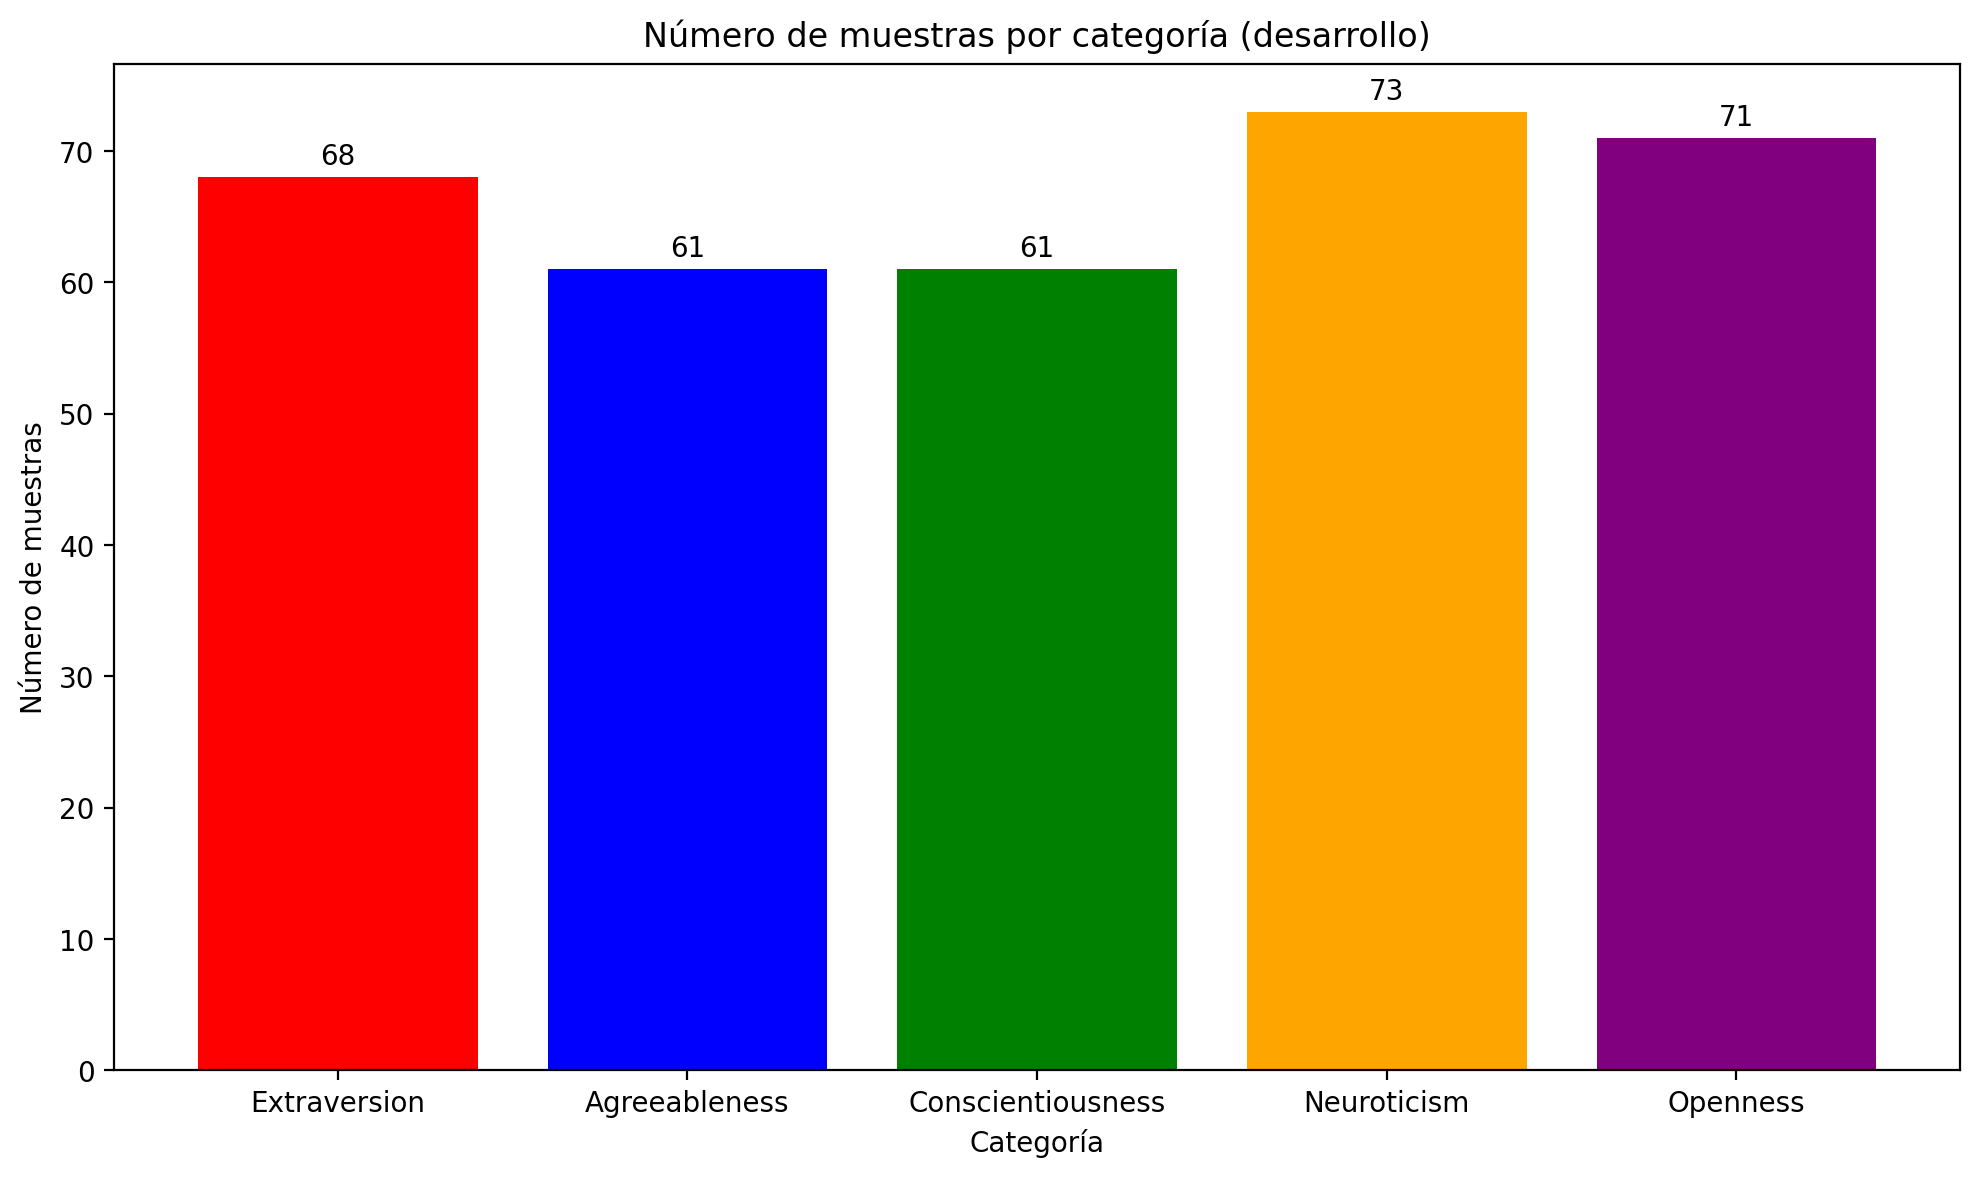

In [102]:
muestras = [len(y_dev_extraversion), len(y_dev_agreeableness), len(y_dev_conscientiousness), len(y_dev_neuroticism), len(y_dev_openness)]

plot_sample_distribution(categorias, muestras, colors, 'Número de muestras por categoría (desarrollo)')

#### Test

In [14]:
# Obten los indices de y_train donde el primer valor de cada vector sea igual a 1
y_test_extraversion = [i for i, x in enumerate(y_test) if x[0] == 1]
y_test_agreeableness = [i for i, x in enumerate(y_test) if x[1] == 1]
y_test_conscientiousness = [i for i, x in enumerate(y_test) if x[2] == 1]
y_test_neuroticism = [i for i, x in enumerate(y_test) if x[3] == 1]
y_test_openness = [i for i, x in enumerate(y_test) if x[4] == 1]

In [15]:
# Obtener los valores de tfidf_raw_text que corresponden a los indices de y_train_extraversion
tfidf_raw_text_extraversion_test = [test['raw_text_no_lbls'][i] for i in y_test_extraversion]
tfidf_raw_text_agreeableness_test = [test['raw_text_no_lbls'][i] for i in y_test_agreeableness]
tfidf_raw_text_conscientiousness_test = [test['raw_text_no_lbls'][i] for i in y_test_conscientiousness]
tfidf_raw_text_neuroticism_test = [test['raw_text_no_lbls'][i] for i in y_test_neuroticism]
tfidf_raw_text_openness_test = [test['raw_text_no_lbls'][i] for i in y_test_openness]

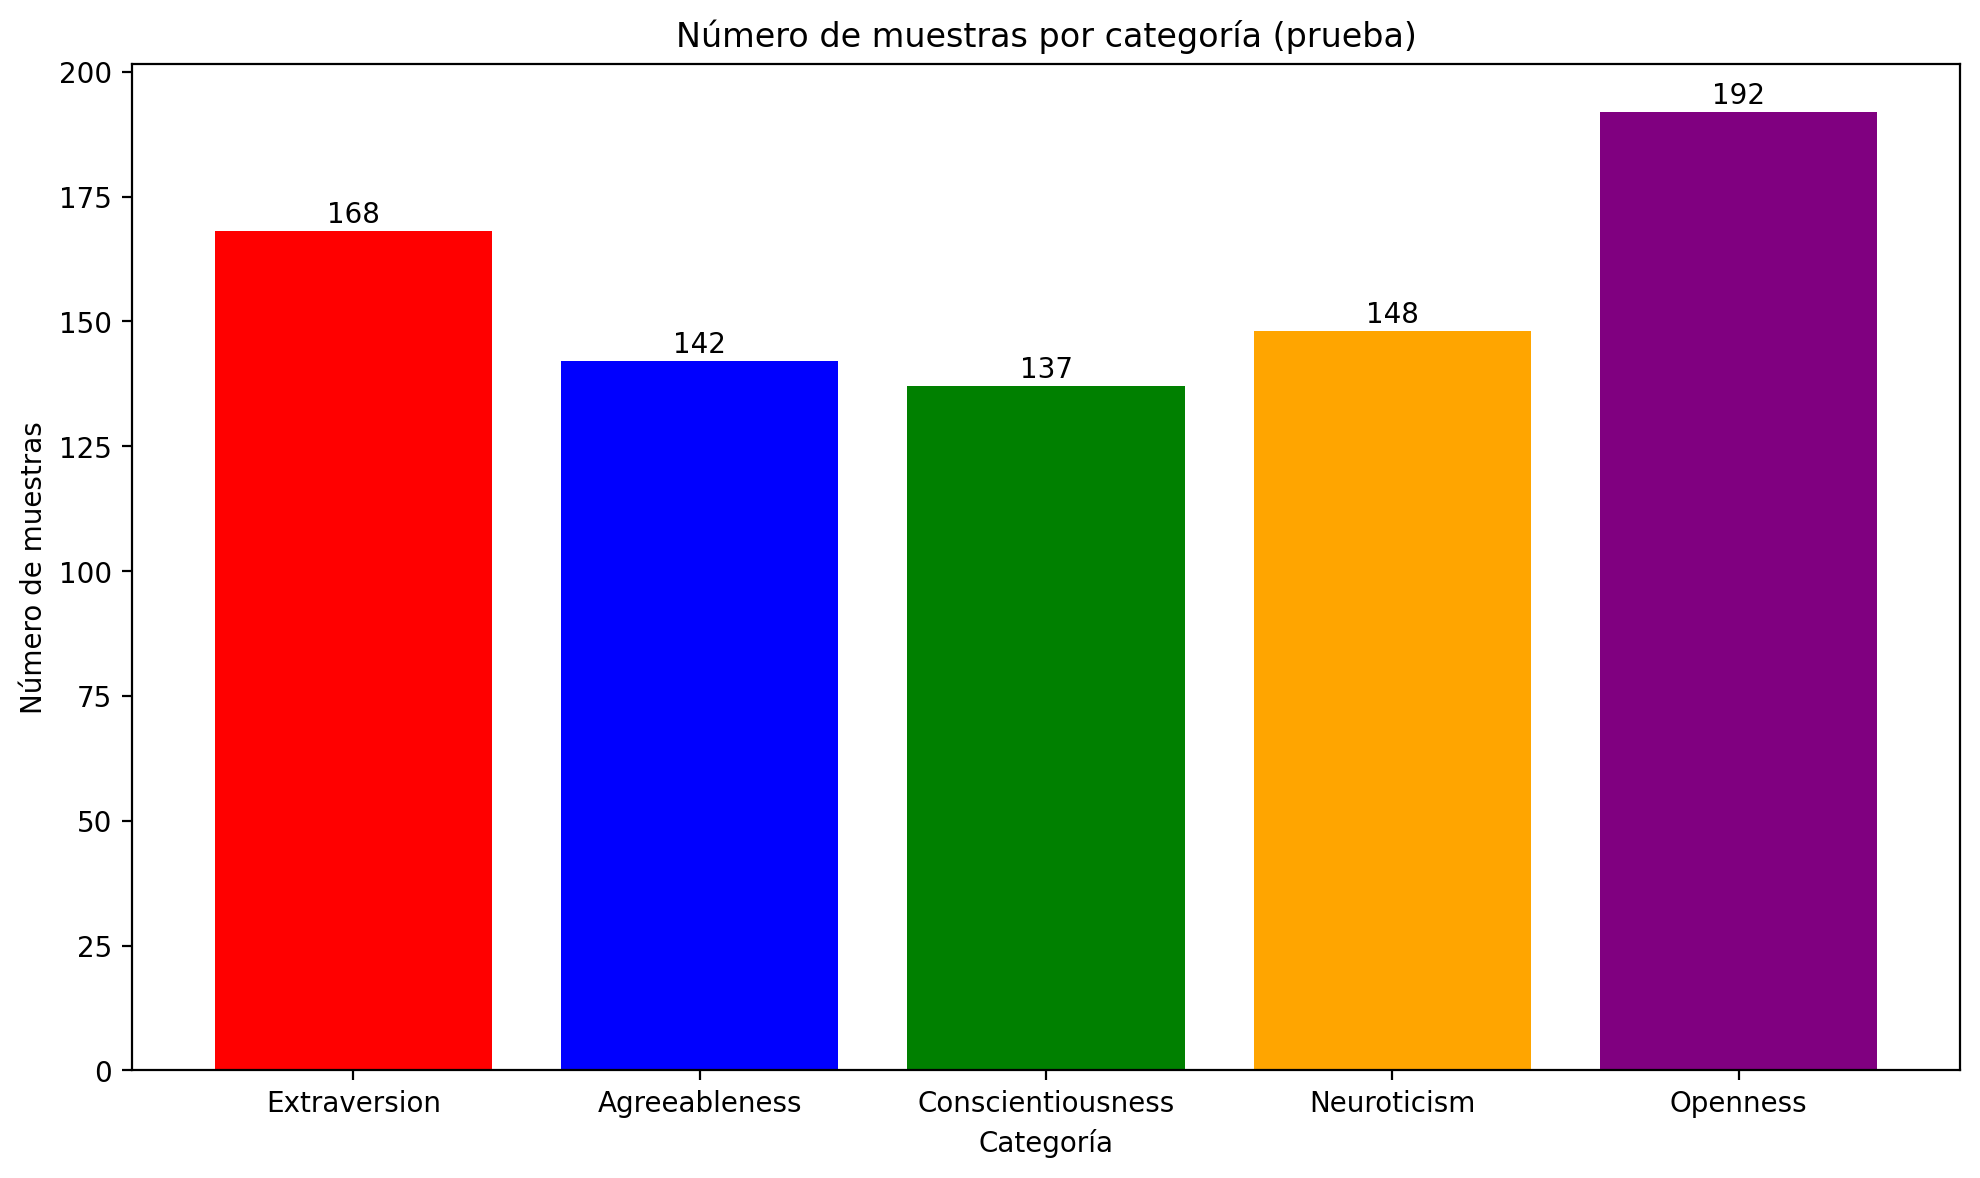

In [103]:
muestras = [len(y_test_extraversion), len(y_test_agreeableness), len(y_test_conscientiousness), len(y_test_neuroticism), len(y_test_openness)]

plot_sample_distribution(categorias, muestras, colors, 'Número de muestras por categoría (prueba)')

### Vectorizar

In [17]:
# Stopwords a lista
stop_words_esp = list(stopwords)

In [18]:

vectorizer_extraversion, tfidf_train_extraversion, tfidf_test_extraversion = vectorize_text(train_data=tfidf_raw_text_extraversion, 
                                                    test_data=[tfidf_raw_text_extraversion_dev, tfidf_raw_text_extraversion_test], 
                                                    min_df=3, ngrams=(1, 1), stop_words_lang=stop_words_esp)

### Red

In [ ]:
updated_weights, M_spikes, M, spikemon_in, spikemon_out = snn_vanilla_4_text(tfidf_matrix=tfidf_train_extraversion, 
                                                        input_neuron_number=len(tfidf_train_extraversion[0]))

In [33]:
print('No of spikes from input: {}'.format(spikemon_in.num_spikes))
print('No of spikes from output: {}'.format(spikemon_out.num_spikes))

No of spikes from input: 4
No of spikes from output: 50


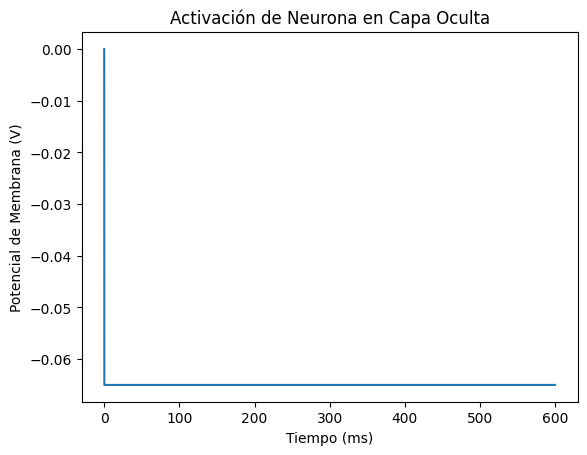

In [29]:
plt.plot(M.t/ms, M.u[49])
plt.xlabel('Tiempo (ms)')
plt.ylabel('Potencial de Membrana (V)')
plt.title('Activación de Neurona en Capa Oculta')
plt.show()

In [ ]:
M_spikes, M, spikemon_in, spikemon_out = snn_vanilla_4_text(tfidf_matrix=tfidf_train_extraversion, 
                                                        input_neuron_number=len(tfidf_train_extraversion[0]))

In [22]:
M[0].u

array([[  0., -65., -65., ..., -65., -65., -65.],
       [  0., -65., -65., ..., -65., -65., -65.],
       [  0., -65., -65., ..., -65., -65., -65.],
       ...,
       [  0., -65., -65., ..., -65., -65., -65.],
       [  0., -65., -65., ..., -65., -65., -65.],
       [  0., -65., -65., ..., -65., -65., -65.]]) * mvolt

In [23]:
spikemon_out[0].t, M[0].u[0]

(<spikemonitor_2.t: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) * second>,
 array([  0., -65., -65., ..., -65., -65., -65.]) * mvolt)

[  0. -65. -65. ... -65. -65. -65.] mV


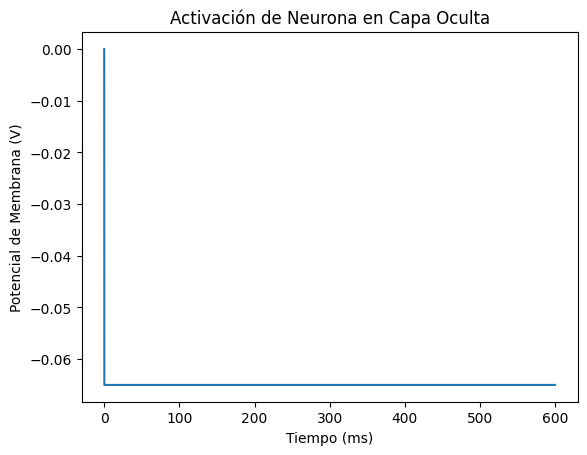

In [26]:
plt.plot(M[0].t/ms, M[0].u[0])
plt.xlabel('Tiempo (ms)')
plt.ylabel('Potencial de Membrana (V)')
plt.title('Activación de Neurona en Capa Oculta')
plt.show()

### SDTP básica

In [50]:
train.head()

,ID,raw_text,raw_text_no_lbls,corrected_text,corrected_text_no_lbls,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness
0,DSC_0085,Fuí MISSPELLED con mí MISSPELLED familia a Ve...,"Fuí con mí familia a Veracruz , me la pase m...",Fuí MISSPELLED con mí MISSPELLED familia a Ve...,"Fui con mi familia a Veracruz , me la pase m...",0,1,1,0,0
1,DSC_0084,- Mi entrada a la Universidad - Creación de...,- Mi entrada a la Universidad - Creación de...,- Mi entrada a la Universidad - Creación de...,- Mi entrada a la Universidad - Creación de...,1,1,1,0,0
2,DSC_0087,Nací en Guanajuato pero me mudé a México cuand...,Nací en Guanajuato pero me mudé a México cuand...,Nací en Guanajuato pero me mudé a México cuand...,Nací en Guanajuato pero me mudé a México cuand...,1,0,0,1,0
3,DSC_0086,Entrar a la universidad y crear mi propia empr...,Entrar a la universidad y crear mi propia empr...,Entrar a la universidad y crear mi propia empr...,Entrar a la universidad y crear mi propia empr...,0,1,1,0,1
4,DSC_0081,Paso por un momento confuso mi familia me apo...,Paso por un momento confuso mi familia me apo...,Paso por un momento confuso mi familia me apo...,Paso por un momento confuso mi familia me apo...,0,0,0,0,1


In [51]:

vectorizer_extraversion, tfidf_train_extraversion, tfidf_test_extraversion = vectorize_text(train_data=train['raw_text'], 
                                                    test_data=[tfidf_raw_text_extraversion, tfidf_raw_text_extraversion_dev, tfidf_raw_text_extraversion_test], 
                                                    min_df=3, ngrams=(1, 1), stop_words_lang=stop_words_esp)

In [53]:
tfidf_train_extraversion.shape, tfidf_test_extraversion[0].shape, tfidf_test_extraversion[1].shape, tfidf_test_extraversion[2].shape

((418, 1146), (186, 1146), (68, 1146), (168, 1146))

In [106]:
def normalize_tfidf_vectors(tfidf_matrix):
    """
    Normaliza los vectores TF-IDF para que estén en una escala adecuada para
    ser utilizados como tasas de disparo en una red de neuronas de Poisson.
    """
    tfidf_matrix = np.array(tfidf_matrix)
    normalized = (tfidf_matrix - np.min(tfidf_matrix)) / (np.max(tfidf_matrix) - np.min(tfidf_matrix)) * 255
    return normalized

In [108]:
def lif_sdtp_vanilla(n_features, tfidf_matrix):
    # Configuración inicial de Brian2
    start_scope()

    # Parámetros STDP y neuronales
    sigma = 0.3
    taupre = 5*ms
    taupost = 8*ms
    wmax = 1.2
    wmin = -0.5
    Apre = 0.4*sigma
    Apost = -0.2*sigma
    tau = 10*ms
    vr = 0*volt
    vt = 1.5*mV

    eqs = '''
    dv/dt = -v/tau : volt (unless refractory)
    '''

    # Inicialización de pesos
    S_initial = np.random.uniform(low=0, high=0.1, size=(1, n_features))

    # Proceso de simulación para cada documento
    for document_vector in tfidf_matrix:
        G = NeuronGroup(1, eqs, threshold='v>vt', reset='v=vr', refractory=1.5*ms, method='linear')
        P = PoissonGroup(n_features, rates=document_vector*Hz)
        
        S = Synapses(P, G,
                    '''
                    w : 1
                    dapre/dt = -apre/taupre : 1 (event-driven)
                    dapost/dt = -apost/taupost : 1 (event-driven)
                    ''',
                    on_pre='''
                    v_post += w*mV
                    apre += Apre
                    w = clip(w+apost, wmin, wmax)
                    ''',
                    on_post='''
                    apost += Apost
                    w = clip(w+apre, wmin, wmax)
                    ''')

        S.connect()
        S.w = S_initial
        
        M = StateMonitor(G, 'v', record=True)
        spikemon_in = SpikeMonitor(P)
        spikemon_out = SpikeMonitor(G)
        
        run(100*ms)  # Ajusta la duración de la simulación según sea necesario

        # Opcional: Actualizar S_initial con los pesos aprendidos para el siguiente documento
        S_initial = S.w[:]
    
    return S, M, spikemon_in, spikemon_out

In [115]:
# Normalizando los vectores TF-IDF de todas las clases
extraversion_norm, agreeableness_norm, conscientiousness_norm, neuroticism_norm, openness_norm = [], [], [], [], []
for i in range(5):
    if i == 0:
        vectorizer, tfidf_train, tfidf_test_extraversion = vectorize_text(train['raw_text'], 
                                                    test_data=[tfidf_raw_text_extraversion, tfidf_raw_text_extraversion_dev, tfidf_raw_text_extraversion_test], 
                                                    min_df=3, ngrams=(1, 1), stop_words_lang=stop_words_esp)
        for tfidf in tfidf_test_extraversion:
            tfidf = normalize_tfidf_vectors(tfidf)
            extraversion_norm.append(tfidf)

    if i == 1:
        vectorizer, tfidf_train, tfidf_test_agreeableness = vectorize_text(train['raw_text'], 
                                                    test_data=[tfidf_raw_text_agreeableness, tfidf_raw_text_agreeableness_dev, tfidf_raw_text_agreeableness_test], 
                                                    min_df=3, ngrams=(1, 1), stop_words_lang=stop_words_esp)
        for tfidf in tfidf_test_agreeableness:
            tfidf = normalize_tfidf_vectors(tfidf)
            agreeableness_norm.append(tfidf)

    if i == 2:
        vectorizer, tfidf_train, tfidf_test_conscientiousness = vectorize_text(train['raw_text'], 
                                                    test_data=[tfidf_raw_text_conscientiousness, tfidf_raw_text_conscientiousness_dev, tfidf_raw_text_conscientiousness_test], 
                                                    min_df=3, ngrams=(1, 1), stop_words_lang=stop_words_esp)
        for tfidf in tfidf_test_conscientiousness:
            tfidf = normalize_tfidf_vectors(tfidf)
            conscientiousness_norm.append(tfidf)

    if i == 3:
        vectorizer, tfidf_train, tfidf_test_neuroticism = vectorize_text(train['raw_text'], 
                                                    test_data=[tfidf_raw_text_neuroticism, tfidf_raw_text_neuroticism_dev, tfidf_raw_text_neuroticism_test], 
                                                    min_df=3, ngrams=(1, 1), stop_words_lang=stop_words_esp)
        for tfidf in tfidf_test_neuroticism:
            tfidf = normalize_tfidf_vectors(tfidf)
            neuroticism_norm.append(tfidf)

    if i == 4:
        vectorizer, tfidf_train, tfidf_test_openness = vectorize_text(train['raw_text'], 
                                                    test_data=[tfidf_raw_text_openness, tfidf_raw_text_openness_dev, tfidf_raw_text_openness_test], 
                                                    min_df=3, ngrams=(1, 1), stop_words_lang=stop_words_esp)
        for tfidf in tfidf_test_openness:
            tfidf = normalize_tfidf_vectors(tfidf)
            openness_norm.append(tfidf)

In [ ]:

vectorizer_extraversion, tfidf_train_extraversion, tfidf_test_extraversion = vectorize_text(train_data=train['raw_text'], 
                                                    test_data=[tfidf_raw_text_extraversion, tfidf_raw_text_extraversion_dev, tfidf_raw_text_extraversion_test], 
                                                    min_df=3, ngrams=(1, 1), stop_words_lang=stop_words_esp)

In [111]:
S_extraversion, M_extraversion, spikemon_in_extraversion, spikemon_out_extraversion = lif_sdtp_vanilla(n_features=len(tfidf_train_extraversion[0]), 
                                                                                                    tfidf_matrix=normalized_tfidf)

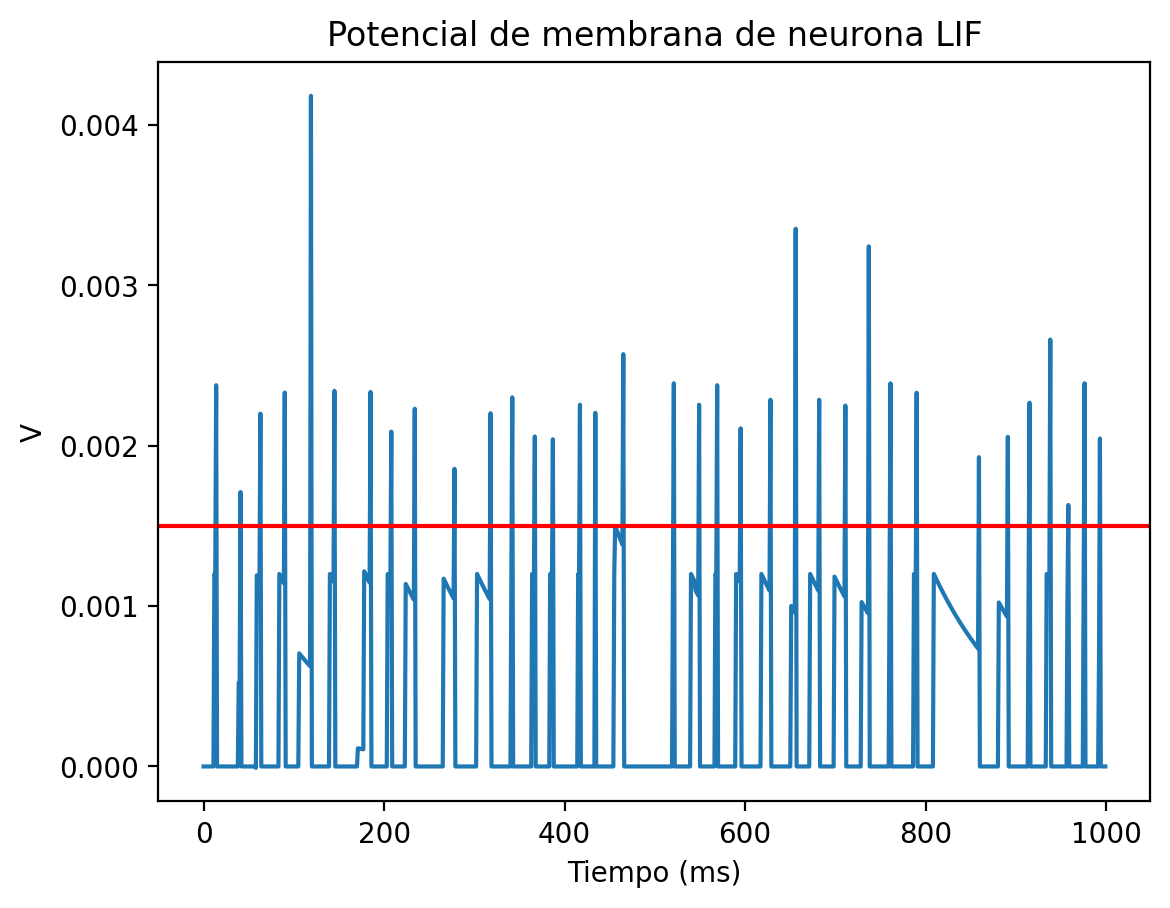

In [112]:
# Visualise first 1000 time steps
plot(M_extraversion.v[0][:])
axhline(1.5/1000, color='r')
title('Potencial de membrana de neurona LIF')
xlabel('Tiempo (ms)')
ylabel('V')
show()

In [127]:
print('No of spikes from input: {}'.format(spikemon_in_extraversion.num_spikes))
print('No of spikes from output: {}'.format(spikemon_out_extraversion.num_spikes))

No of spikes from input: 203
No of spikes from output: 36


In [ ]:
for i in range(5):
    if i == 0:
        S_extraversion, M_extraversion, spikemon_in_extraversion, spikemon_out_extraversion = lif_sdtp_vanilla(n_features=len(extraversion_norm[0][0]), 
                                                                                                    tfidf_matrix=extraversion_norm[0])
    if i == 1:
        S_agreeableness, M_agreeableness, spikemon_in_agreeableness, spikemon_out_agreeableness = lif_sdtp_vanilla(n_features=len(agreeableness_norm[0][0]), 
                                                                                                    tfidf_matrix=agreeableness_norm[0])
    if i == 2:
        S_conscientiousness, M_conscientiousness, spikemon_in_conscientiousness, spikemon_out_conscientiousness = lif_sdtp_vanilla(n_features=len(conscientiousness_norm[0][0]), 
                                                                                                    tfidf_matrix=conscientiousness_norm[0])
    if i == 3:
        S_neuroticism, M_neuroticism, spikemon_in_neuroticism, spikemon_out_neuroticism = lif_sdtp_vanilla(n_features=len(neuroticism_norm[0][0]), 
                                                                                                    tfidf_matrix=neuroticism_norm[0])
    if i == 4:
        S_openness, M_openness, spikemon_in_openness, spikemon_out_openness = lif_sdtp_vanilla(n_features=len(openness_norm[0][0]), 
                                                                                                    tfidf_matrix=openness_norm[0])

In [120]:
s_extraversion, m_extraversion, spikemon_in_extraversion, spikemon_out_extraversion = lif_sdtp_vanilla(n_features=len(extraversion_norm[0][0]), 
                                                                                                    tfidf_matrix=extraversion_norm[0])

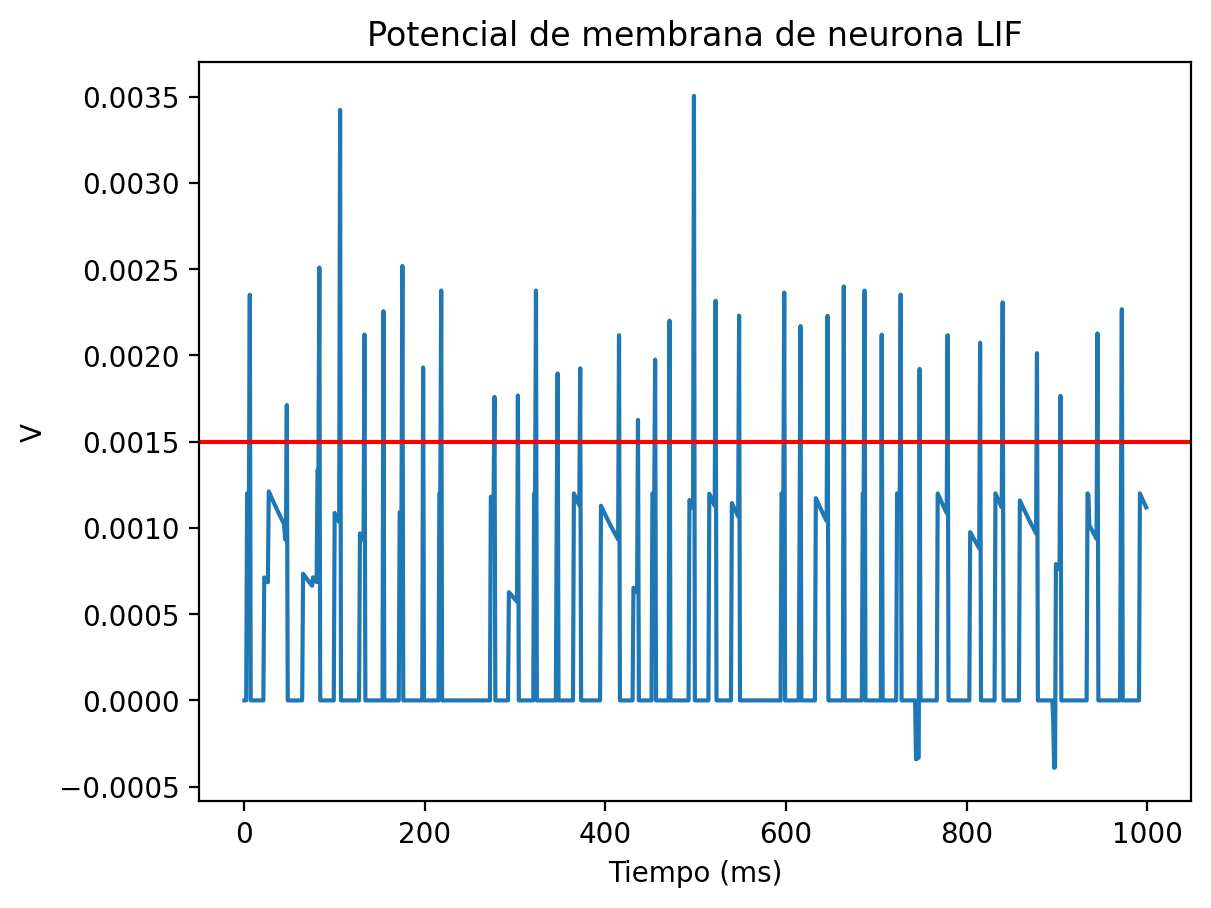

In [121]:
# Visualise first 1000 time steps
plot(m_extraversion.v[0][:])
axhline(1.5/1000, color='r')
title('Potencial de membrana de neurona LIF')
xlabel('Tiempo (ms)')
ylabel('V')
show()

In [55]:
# Configuración inicial de Brian2
start_scope()

# Parámetros STDP y neuronales
sigma = 0.3
taupre = 5*ms
taupost = 8*ms
wmax = 1.2
wmin = -0.5
Apre = 0.4*sigma
Apost = -0.2*sigma
tau = 10*ms
vr = 0*volt
vt = 1.5*mV
eqs = '''
dv/dt = -v/tau : volt (unless refractory)
'''

# Inicialización de pesos
n_features = normalized_tfidf.shape[1]  # Número de características (términos)
S_initial = np.random.uniform(low=0, high=0.1, size=(1, n_features))

# Proceso de simulación para cada documento
for document_vector in normalized_tfidf:
    G = NeuronGroup(1, eqs, threshold='v>vt', reset='v=vr', refractory=1.5*ms, method='linear')
    P = PoissonGroup(n_features, rates=document_vector*Hz)
    
    S = Synapses(P, G,
                 '''
                 w : 1
                 dapre/dt = -apre/taupre : 1 (event-driven)
                 dapost/dt = -apost/taupost : 1 (event-driven)
                 ''',
                 on_pre='''
                 v_post += w*mV
                 apre += Apre
                 w = clip(w+apost, wmin, wmax)
                 ''',
                 on_post='''
                 apost += Apost
                 w = clip(w+apre, wmin, wmax)
                 ''')

    S.connect()
    S.w = S_initial
    
    M = StateMonitor(G, 'v', record=True)
    spikemon_in = SpikeMonitor(P)
    spikemon_out = SpikeMonitor(G)
    
    run(100*ms)  # Ajusta la duración de la simulación según sea necesario

    # Opcional: Actualizar S_initial con los pesos aprendidos para el siguiente documento
    S_initial = S.w[:]

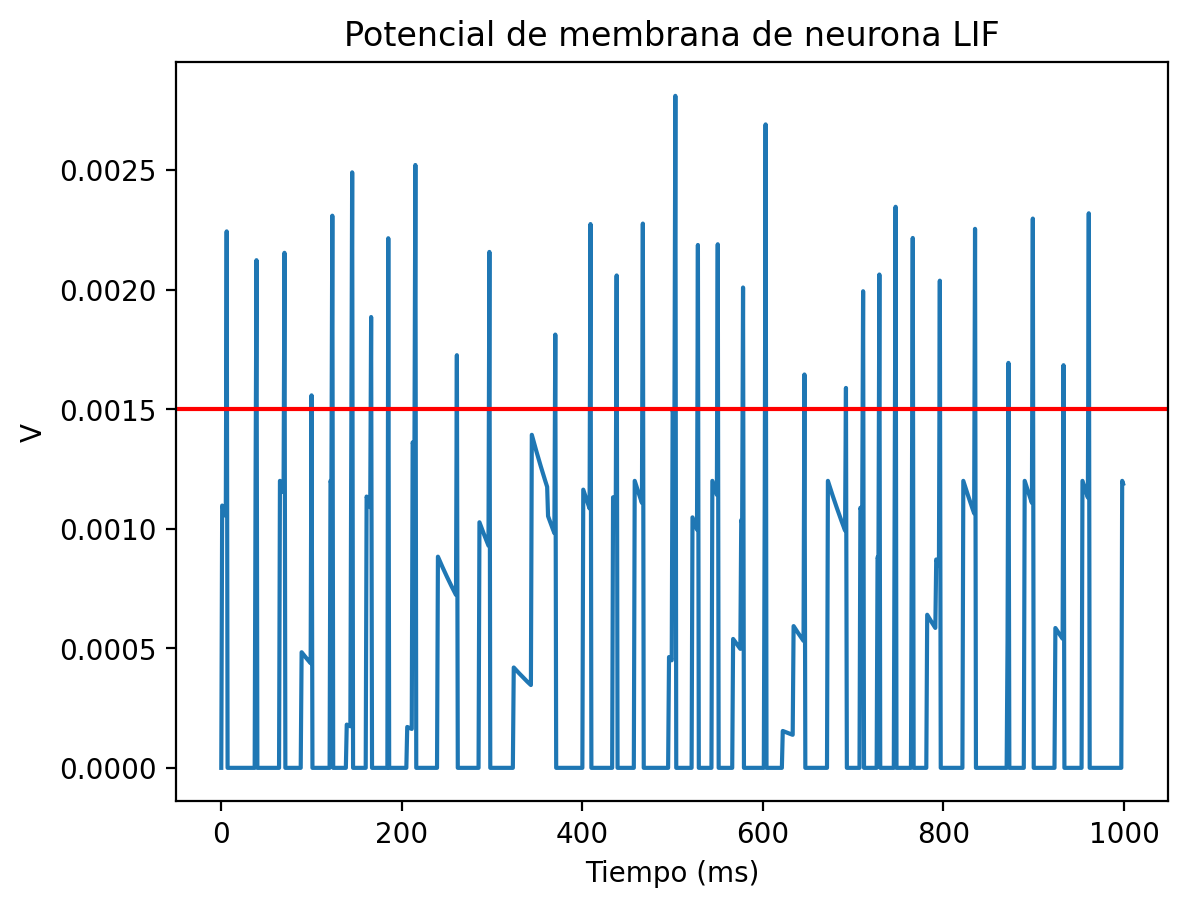

In [80]:
# Visualise first 1000 time steps
plot(M.v[0][:])
axhline(1.5/1000, color='r')
title('Potencial de membrana de neurona LIF')
xlabel('Tiempo (ms)')
ylabel('V')
show()

In [58]:
print('No of spikes from input: {}'.format(spikemon_in.num_spikes))
print('No of spikes from output: {}'.format(spikemon_out.num_spikes))

No of spikes from input: 164
No of spikes from output: 32


In [67]:
vectorizer_neuroticism, tfidf_train_neuroticism, tfidf_test_neuroticism = vectorize_text(train_data=train['raw_text'], 
                                                    test_data=[tfidf_raw_text_neuroticism, tfidf_raw_text_neuroticism_dev, tfidf_raw_text_neuroticism_test], 
                                                    min_df=3, ngrams=(1, 1), stop_words_lang=stop_words_esp)

In [68]:
tfidf_train_neuroticism.shape, tfidf_test_neuroticism[0].shape, tfidf_test_neuroticism[1].shape, tfidf_test_neuroticism[2].shape

((418, 1146), (177, 1146), (73, 1146), (148, 1146))

In [81]:
# Supongamos que test_tfidf representa algunos vectores TF-IDF de prueba que ya están normalizados
test_tfidf = normalize_tfidf_vectors(tfidf_train_neuroticism[0])  # Normalizamos un documento de prueba como ejemplo

start_scope()

# Usamos las mismas ecuaciones neuronales y parámetros STDP (sin actualizaciones de peso)
for document_vector in test_tfidf:

    G_test = NeuronGroup(1, eqs, threshold='v>vt', reset='v=vr', refractory=1.5*ms, method='linear')
    P_test = PoissonGroup(n_features, rates=document_vector*Hz)

    S_test = Synapses(P_test, G_test,
                      '''
                      w : 1
                      dapre/dt = -apre/taupre : 1 (event-driven)
                      dapost/dt = -apost/taupost : 1 (event-driven)
                      ''',
                      on_pre='''
                      v_post += w*mV
                      apre += Apre
                      ''',
                      on_post='''
                      apost += Apost
                      ''')

    S_test.connect()
    S_test.w = S.w  # Cargar los pesos entrenados

    M_test = StateMonitor(G_test, 'v', record=True)
    test_spikemon = SpikeMonitor(G_test)
    
    run(100*ms)  # Ajustar según sea necesario

    # Imprimir o analizar test_spikemon.num_spikes para ver la respuesta de la red
    print("Número de picos para el documento de prueba:", test_spikemon.num_spikes)


Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de picos para el documento de prueba: 0
Número de pic